In [1]:
%matplotlib inline
import spotipy
import pandas as pd
import matplotlib.pyplot as plt
from spotipy.oauth2 import SpotifyClientCredentials
from spotipy.client import SpotifyException
from ClientCredentials import client_id, client_secret
pd.set_option('display.max_colwidth', 30)
pd.set_option('display.max_columns', 0)
pd.set_option('display.expand_frame_repr', False)

In [2]:
# Logging in
username = "113586775"

client_credentials_manager = SpotifyClientCredentials(client_id=client_id, client_secret=client_secret)
spotify = spotipy.Spotify(client_credentials_manager=client_credentials_manager)

In [3]:
# Which tracks was released in 2018?
release_date = []
artist_name = []
track_name = []
popularity = []
track_id = []

for i in range(0,10000,50):
    try:
        track_results = spotify.search(q='year:2018', type='track', limit=50, offset=i)
    except SpotifyException:
        print(i)
        break
    for t in track_results['tracks']['items']:
        release_date.append(t['album']['release_date'])
        artist_name.append(t['artists'][0]['name'])
        track_name.append(t['name'])
        track_id.append(t['id'])
        popularity.append(t['popularity'])


HTTP Error for GET to https://api.spotify.com/v1/search returned 404 due to Not found.
2000


In [4]:
# Creating a dataframe
track_df = pd.DataFrame(
    {
        'release_date': release_date,
        'artist_name': artist_name,
        'track_name': track_name,
        'track_id': track_id,
        'popularity': popularity
    }
)
track_df['release_date'] = pd.to_datetime(track_df['release_date'])
track_df.sort_values(by='release_date', inplace=True, ignore_index=True)
# ignore_index=True: updates the indices of the dataframe

print(f"Dataframe shape: {track_df.shape}")
print("\n", track_df.head(10))
print("\n", track_df.describe())
print("\n", track_df.dtypes)

Dataframe shape: (2000, 5)

   release_date     artist_name                   track_name                track_id  popularity
0   2018-01-01        Cavetown                         Fool  7asyVbwQE7IbA3x2be7bdI          71
1   2018-01-01        Cavetown                    Lemon Boy  3Yvk0ZLxMlt6ioasvdN6vB          72
2   2018-01-01     Riley Green             Bury Me In Dixie  7KFbFqfBxqRtSSwkA874iv          64
3   2018-01-01     Beach Bunny                       Sports  77G0k1La0c5Dw8bAFANcyp          71
4   2018-01-01        Cavetown                        Green  2PfkfkaO9okAk0OxC4ggy5          64
5   2018-01-03        MOMOLAND                  BBoom BBoom  3BPoSr2pO34Aan6alFfVto          70
6   2018-01-04        Upchurch    Shoulda Named It After Me  01oxuDv2GsOoj6xxhaM8eL          63
7   2018-01-04  Kendrick Lamar     All The Stars (with SZA)  66kQ7wr4d2LwwSjr7HXcyr          63
8   2018-01-04       RichaadEB                  Bad Apple!!  4Cf79mYekC12YWNw13Va8r          63
9   2018-01

No. artists:  850


<AxesSubplot:>

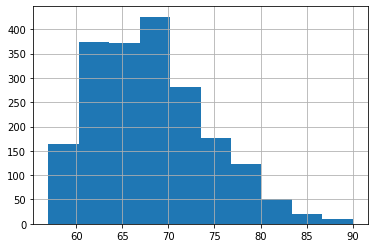

In [5]:
print("No. artists: ", track_df['artist_name'].nunique())

track_df['popularity'].hist()

In [6]:
# Which playlists do I have?
playlists = spotify.user_playlists(username)
print("Type: ", type(playlists))
print("Keys: ", playlists.keys())
print()

playlist_name = []
playlist_ntracks = []
playlist_id = []

for p in playlists['items']:
    playlist_name.append(p['name'])
    playlist_ntracks.append(p['tracks']['total'])
    playlist_id.append(p['id'])

playlist_df = pd.DataFrame(
    {'n_tracks': playlist_ntracks, 'id': playlist_id}, 
    index=playlist_name
    )
print(playlist_df)
print("Number of tracks in Favorites-playlist: ", playlist_df['n_tracks']['Favorites'])

Type:  <class 'dict'>
Keys:  dict_keys(['href', 'items', 'limit', 'next', 'offset', 'previous', 'total'])

                                n_tracks                      id
Favorites                           1030  2tvrDqnp3vJd6l6Cw38bVZ
Queen and other classics             105  367BXl0oqvDSbBu34T6OBH
John Mayer                           211  4h69xgBmpi8WnrCzNG0saL
Global Top 50                         50  37i9dQZEVXbMDoHDwVN2tF
Rock                                  80  2k19D3M2QSz3sdS0MzocSs
Party                                477  1Vs71OxUMfNXTLtp4USgTA
Blues                                 49  5na5MdXxNrFa7JUUwg14qP
Piano                                 32  4qa6CoQZqpUun4Divl1Cjg
Rock du kender                       152  37i9dQZF1DXcSNirXzsHRX
Tolkiens The Lord of the Ri...        78  4F3VK81yAvFlVquazfxVLG
Number of tracks in Favorites-playlist:  1030


In [7]:
artists = []
unique_artists = []
track_name = []
release_date = []
duration_ms = []
popularity = []
track_id = []

for i in range(0, playlist_df['n_tracks'].Favorites, 100):
    # track_results = spotify.search(q='year:2018', type='track', limit=50, offset=i)
    track_results = spotify.user_playlist_tracks(username, playlist_df['id'].Favorites, offset=i, limit=100)
    for track in track_results['items']:
        artists.append({artist['name'] for artist in track['track']['artists']})
        for artist in track['track']['artists']:
            if artist['name'] not in unique_artists:
                unique_artists.append(artist['name'])
        track_name.append(track['track']['name'])
        release_date.append(track['track']['album']['release_date'])
        duration_ms.append(track['track']['duration_ms'])
        popularity.append(track['track']['popularity'])
        track_id.append(track['track']['id'])



In [8]:
artists_df = pd.DataFrame(artists, columns=[f"Artist {i + 1}" for i in range(max(map(len, artists)))])

favorites_df = pd.DataFrame(
    {
        'release_date': release_date,
        'track_name': track_name,
        'duration_ms': duration_ms,
        'popularity': popularity,
        'track_id': track_id
    }
)
favorites_df['release_date'] = pd.to_datetime(favorites_df['release_date'])

favorites_df = pd.concat([favorites_df, artists_df], axis=1)
favorites_df.sort_values(by='release_date', inplace=True, ascending=False, ignore_index=True)
favorites_df

,release_date,track_name,duration_ms,popularity,track_id,Artist 1,Artist 2,Artist 3,Artist 4,Artist 5,Artist 6
0,2020-07-30,my future,208155,92,2ygvZOXrIeVL4xZmAWJT2C,Billie Eilish,None,None,None,None,None
1,2020-07-17,Party Girl (Remix),147672,73,1eIsyfDHoEbemSnQFsgyAv,Lil Uzi Vert,StaySolidRocky,None,None,None,None
2,2020-07-16,Sixteen,201226,67,6p6KdVpfKtTMisH5VfWqsL,Ellie Goulding,None,None,None,None,None
3,2020-05-29,Ur So F**kInG cOoL,172746,83,6KiEsqGg0HBOSMflVH7Onx,Tones And I,None,None,None,None,None
4,2020-05-29,Rain On Me (with Ariana Gr...,182200,87,7ju97lgwC2rKQ6wwsf9no9,Lady Gaga,Ariana Grande,None,None,None,None
...,...,...,...,...,...,...,...,...,...,...,...
1025,1970-04-10,Your Song,244226,0,17VegeBoHvMlIByrdu64KR,Elton John,None,None,None,None,None
1026,1968-11-22,Blackbird - Remastered,138386,0,4Z92RMiyJpUrApZi3LtpJ6,The Beatles,None,None,None,None,None
1027,1968-11-22,While My Guitar Gently Wee...,285000,0,4J4gApJKSC0himDViFotdy,The Beatles,None,None,None,None,None
1028,1968-10-25,All Along the Watchtower,240800,78,2aoo2jlRnM3A0NyLQqMN2f,Jimi Hendrix,None,None,None,None,None


,release_date,track_name,Artist 4,Artist 5,Artist 6,popularity,duration_ms,track_id,Artist 2,Artist 1,Artist 3
0,2020-07-30,my future,None,None,None,92,208155,2ygvZOXrIeVL4xZmAWJT2C,None,Billie Eilish,None
1,2020-07-17,Party Girl (Remix),None,None,None,73,147672,1eIsyfDHoEbemSnQFsgyAv,StaySolidRocky,Lil Uzi Vert,None
2,2020-07-16,Sixteen,None,None,None,67,201226,6p6KdVpfKtTMisH5VfWqsL,None,Ellie Goulding,None
3,2020-05-29,Ur So F**kInG cOoL,None,None,None,83,172746,6KiEsqGg0HBOSMflVH7Onx,None,Tones And I,None
4,2020-05-29,Rain On Me (with Ariana Gr...,None,None,None,87,182200,7ju97lgwC2rKQ6wwsf9no9,Ariana Grande,Lady Gaga,None
...,...,...,...,...,...,...,...,...,...,...,...
1025,1970-04-10,Your Song,None,None,None,0,244226,17VegeBoHvMlIByrdu64KR,None,Elton John,None
1026,1968-11-22,Blackbird - Remastered,None,None,None,0,138386,4Z92RMiyJpUrApZi3LtpJ6,None,The Beatles,None
1027,1968-11-22,While My Guitar Gently Wee...,None,None,None,0,285000,4J4gApJKSC0himDViFotdy,None,The Beatles,None
1028,1968-10-25,All Along the Watchtower,None,None,None,78,240800,2aoo2jlRnM3A0NyLQqMN2f,None,Jimi Hendrix,None


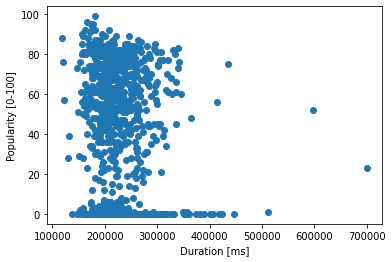

In [10]:
cols = favorites_df.columns
cols = cols[[0, 1, 5, 6, 7, 8, 9, 10, 3, 2, 4]]
favorites_df = favorites_df[cols]

plt.scatter(favorites_df['duration_ms'], favorites_df['popularity'])
plt.xlabel('Duration [ms]')
plt.ylabel('Popularity [0-100]')

favorites_df

In [12]:
spotify.audio_analysis(favorites_df.iloc[0]['track_id'])

116.01832, 'duration': 0.28545, 'confidence': 0.792},
  {'start': 116.30377, 'duration': 0.28573, 'confidence': 0.649},
  {'start': 116.5895, 'duration': 0.28573, 'confidence': 0.649},
  {'start': 116.87523, 'duration': 0.28535, 'confidence': 0.407},
  {'start': 117.16058, 'duration': 0.28535, 'confidence': 0.407},
  {'start': 117.44594, 'duration': 0.28498, 'confidence': 0.267},
  {'start': 117.73092, 'duration': 0.28498, 'confidence': 0.267},
  {'start': 118.0159, 'duration': 0.28488, 'confidence': 0.636},
  {'start': 118.30078, 'duration': 0.28488, 'confidence': 0.636},
  {'start': 118.58566, 'duration': 0.28584, 'confidence': 0.709},
  {'start': 118.8715, 'duration': 0.28584, 'confidence': 0.709},
  {'start': 119.15735, 'duration': 0.28666, 'confidence': 0.813},
  {'start': 119.44401, 'duration': 0.28666, 'confidence': 0.813},
  {'start': 119.73067, 'duration': 0.28616, 'confidence': 0.695},
  {'start': 120.01683, 'duration': 0.28616, 'confidence': 0.695},
  {'start': 120.30299, 'd